## Split CIFAR-10 into training, validation, and testing sets

In [23]:
##########################
### SETTINGS
##########################

NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
lr = 0.001
num_epochs = 60
batch_size = 16

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Visualize image for each class

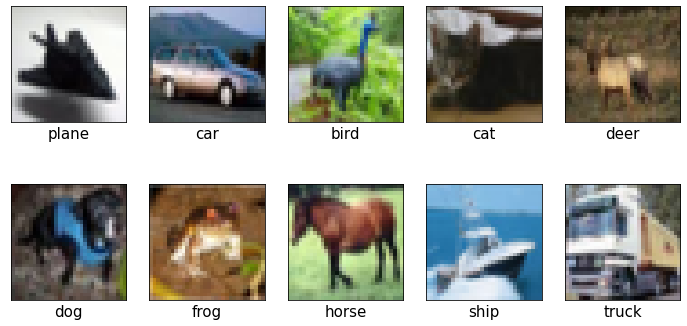

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

net = models.vgg19(pretrained=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Device: cuda:0
Number of trainable parameters: 143667240


## Training

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(int (num_epochs/2)):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 1] loss: 0.18399 accuracy: 0.0977 val loss: 0.14494 val accuracy: 0.1027
[epoch 2] loss: 0.14568 accuracy: 0.1133 val loss: 0.13584 val accuracy: 0.1906
[epoch 3] loss: 0.13088 accuracy: 0.1874 val loss: 0.12309 val accuracy: 0.2260
[epoch 4] loss: 0.12341 accuracy: 0.2091 val loss: 0.12463 val accuracy: 0.2267
[epoch 5] loss: 0.11966 accuracy: 0.2320 val loss: 0.11649 val accuracy: 0.2656
[epoch 6] loss: 0.11588 accuracy: 0.2690 val loss: 0.11549 val accuracy: 0.2864
[epoch 7] loss: 0.10981 accuracy: 0.3192 val loss: 0.10489 val accuracy: 0.3589
[epoch 8] loss: 0.10392 accuracy: 0.3589 val loss: 0.09885 val accuracy: 0.4038
[epoch 9] loss: 0.09962 accuracy: 0.3948 val loss: 0.09793 val accuracy: 0.4123
[epoch 10] loss: 0.09616 accuracy: 0.4179 val loss: 0.09122 val accuracy: 0.4511
[epoch 11] loss: 0.09286 accuracy: 0.4410 val loss: 0.08891 val accuracy: 0.4710
[epoch 12] loss: 0.08946 accuracy: 0.4650 val loss: 0.08350 val accuracy: 0.5044
[epoch 13] loss: 0.08650 accuracy: 0.

In [28]:
from google.colab import files, drive
name = 'vgg19_weigh_epoch' + str(int(num_epochs/2)) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('vgg19_weight.pth')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

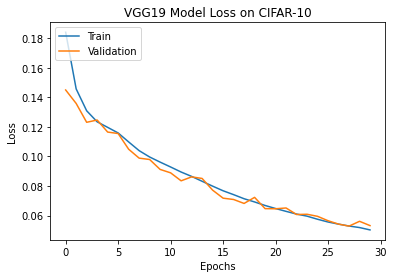

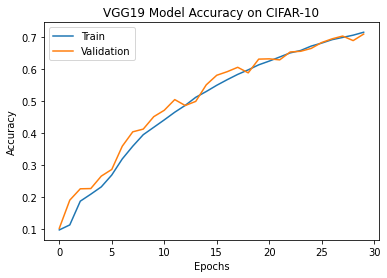

In [30]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('VGG19 Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('VGG19 Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## **Training on 31-60**

In [31]:
for epoch in range(int (num_epochs/2), num_epochs):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 31] loss: 0.04902 accuracy: 0.7216 val loss: 0.05326 val accuracy: 0.7072
[epoch 32] loss: 0.04785 accuracy: 0.7291 val loss: 0.04984 val accuracy: 0.7289
[epoch 33] loss: 0.04635 accuracy: 0.7370 val loss: 0.05041 val accuracy: 0.7220
[epoch 34] loss: 0.04562 accuracy: 0.7412 val loss: 0.04971 val accuracy: 0.7200
[epoch 35] loss: 0.04455 accuracy: 0.7484 val loss: 0.05156 val accuracy: 0.7160
[epoch 36] loss: 0.04336 accuracy: 0.7552 val loss: 0.05325 val accuracy: 0.7091
[epoch 37] loss: 0.04252 accuracy: 0.7611 val loss: 0.04642 val accuracy: 0.7467
[epoch 38] loss: 0.04113 accuracy: 0.7677 val loss: 0.04679 val accuracy: 0.7388
[epoch 39] loss: 0.04046 accuracy: 0.7741 val loss: 0.04739 val accuracy: 0.7452
[epoch 40] loss: 0.03924 accuracy: 0.7801 val loss: 0.04684 val accuracy: 0.7493
[epoch 41] loss: 0.03875 accuracy: 0.7819 val loss: 0.04705 val accuracy: 0.7440
[epoch 42] loss: 0.03807 accuracy: 0.7855 val loss: 0.04464 val accuracy: 0.7629
[epoch 43] loss: 0.03714 acc

In [32]:
from google.colab import files, drive
name = 'vgg19_weigh_epoch' + str(num_epochs) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('vgg19_weight.pth')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

## Plotting training statistics

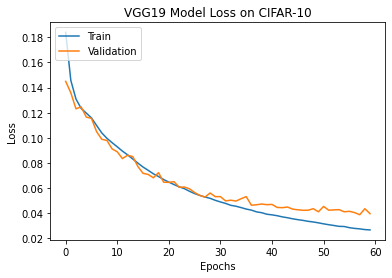

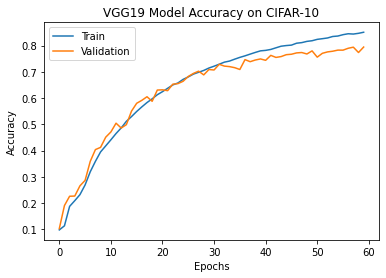

In [34]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('VGG19 Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('VGG19 Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [35]:
from google.colab import files, drive
name = 'vgg19_weigh_epoch' + str(num_epochs) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('vgg19_weight.pth')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

## Testing

In [37]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 79.02 %


## Visualize wrongly classified image for each class

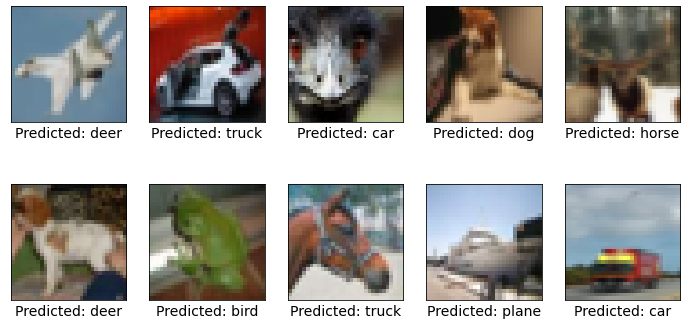

In [38]:
import numpy as np

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
incorrect_mask = pred_vec != ground_truths
incorrect_images = [test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results = [pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1